<a href="https://colab.research.google.com/github/Sant05hkumar06/NLP/blob/main/NLP_of_Email_SPAM_OR_HAM_using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data=pd.read_csv('/content/drive/MyDrive/NLP/SPAM_OR_HAM/spam_ham_dataset.csv', encoding='latin1')

In [6]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)

In [7]:
data.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


Text(0.5, 1.0, 'Spam/ham Data Distribution')

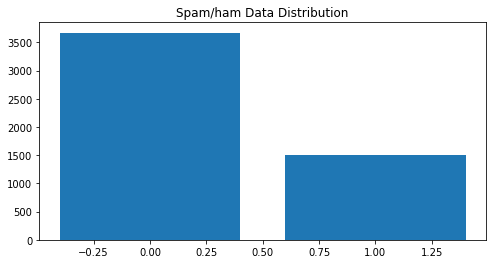

In [8]:
val_count = data.label_num.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Spam/ham Data Distribution")

In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"

In [10]:
data.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [11]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
data.text = data.text.apply(lambda x: preprocess(x))

In [13]:
data.head()

,text,label_num
0,subject: enron methanol ; meter # : 988291 fol...,0
1,"subject: hpl nom january 9 , 2001 ( see attach...",0
2,"subject: neon retreat ho ho ho , ' around wond...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: : indian springs deal book teco pvr r...,0


Text(0.5, 1.0, 'Spam Word Cloud')

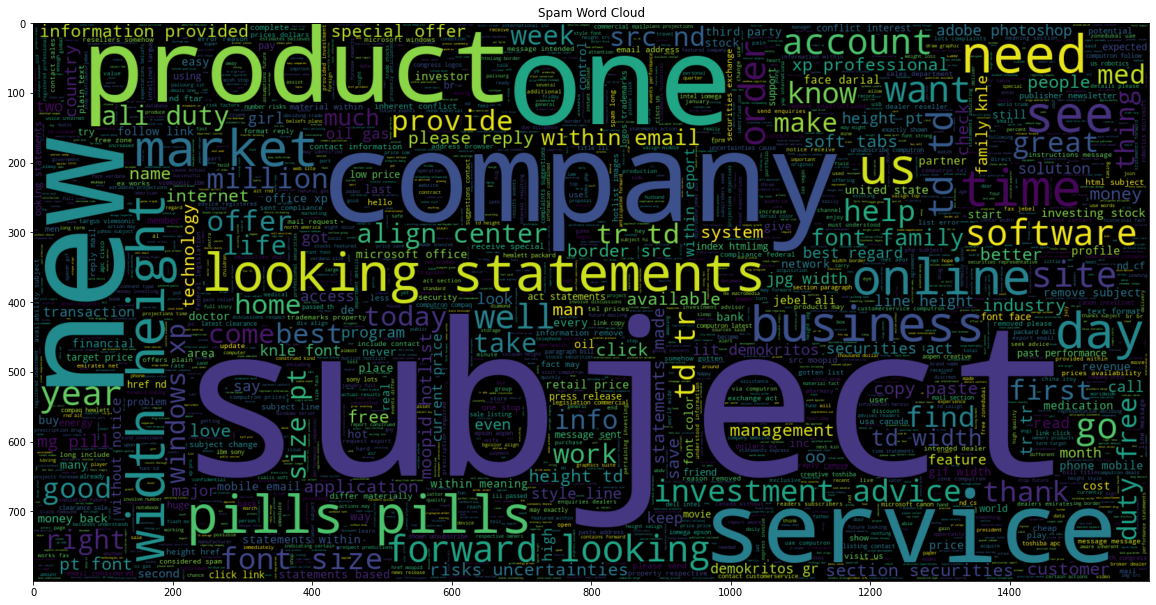

In [14]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.label_num == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Spam Word Cloud")

Text(0.5, 1.0, 'Ham Word Cloud')

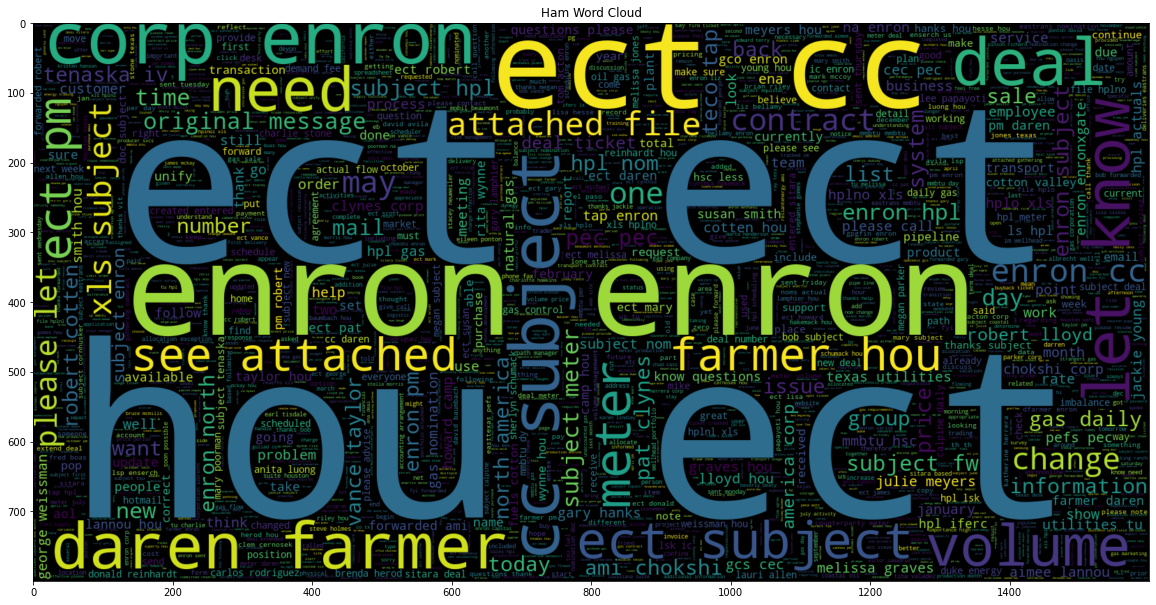

In [15]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.label_num == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Ham Word Cloud")

In [16]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50

In [17]:
x = data['text']
y = data['label_num']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Train Data size: 4136
Test Data size 1035


In [18]:
x_train.head(10)

362     subject: hpl nom january 5 , 2001 ( see attach...
1078    subject: enron / hpl actuals november 1 , 2000...
2421    subject: ponderosa pine energy partners , ltd ...
2331    subject: final cp name change / merger list 08...
2004    subject: enron / hpl actuals october 10 , 2000...
4980    subject: meter 98 - 9699 & 98 - 2662 ( receipt...
1032    subject: fwd : hi paliourg , like watch real p...
2039    subject: : cp & l daren , handling cp & l tryi...
3412    subject: please print - - - - - - - - - forwar...
662     subject: : meter 5892 need help ! john childre...
Name: text, dtype: object

Tokenizer

In [19]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 44790


In [20]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (4136, 50)
Testing X Shape: (1035, 50)


In [21]:
y_test.shape

(1035,)

In [22]:
x_train

array([[    0,     0,     0, ...,  1840,    74,    55],
       [    0,     0,     0, ...,    18,    10,   110],
       [    0,     0,     0, ...,   171,    21,  1008],
       ...,
       [    0,     0,     0, ...,    91, 43775,     7],
       [    0,     0,     0, ...,  2071,  2320, 43780],
       [    0,     0,     0, ...,  5572, 43790,  4406]], dtype=int32)

### LSTM

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [25]:
#LSTM hyperparameters
n_lstm = 200
drop_lstm =0.2
embeding_dim = 16

In [26]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['confusion'])

In [27]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test),callbacks =[early_stop], verbose=2)

Epoch 1/30
130/130 - 46s - loss: 0.3464 - accuracy: 0.8434 - val_loss: 0.1149 - val_accuracy: 0.9674 - 46s/epoch - 352ms/step
Epoch 2/30
130/130 - 28s - loss: 0.0448 - accuracy: 0.9892 - val_loss: 0.1806 - val_accuracy: 0.9620 - 28s/epoch - 214ms/step
Epoch 3/30
130/130 - 28s - loss: 0.0188 - accuracy: 0.9969 - val_loss: 0.1341 - val_accuracy: 0.9728 - 28s/epoch - 214ms/step


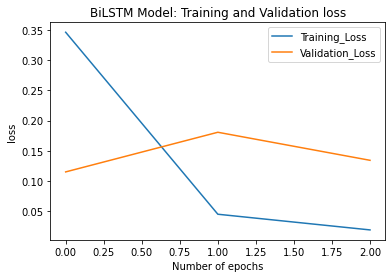

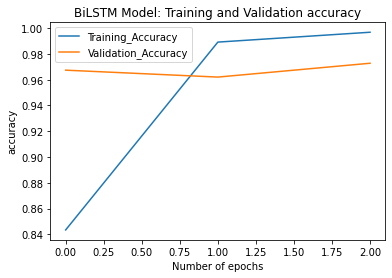

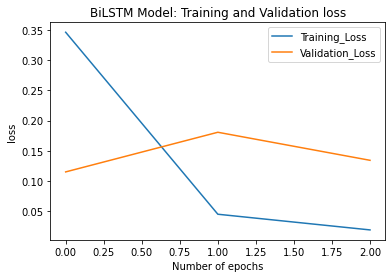

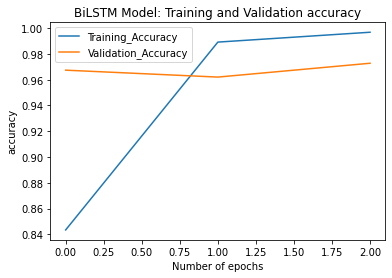

In [28]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [29]:
metrics.head()

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.346375,0.843424,0.114918,0.967420
1,0.044762,0.989207,0.180616,0.962048
2,0.018769,0.996857,0.134125,0.972792


In [30]:
y_pred = model2.predict(x_test)
y_pred.shape

(1035, 50, 1)